In [1]:
import jax
import jax.numpy as jnp
import jax.experimental.mesh_utils as mesh_utils
import jax.numpy as jnp
import jax.random as jr
import jax.sharding as sharding

ModuleNotFoundError: No module named 'jax'

In [2]:
%%capture
!pip install equinox
!pip install easydict
!pip install jaxopt

In [2]:
import equinox as eqx
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import jaxopt

In [3]:
import jax.numpy as jnp


# Function space
class UnitNormVec3RF:
    def __init__(self,  N=12, prngkey=None):
        if prngkey is not None:
            self.key = prngkey
        else:
            self.key = jax.random.PRNGKey(1701)
        self.N = N

        self.freqs = 2*jnp.pi*jnp.arange(-N*1.0, N+1.0, 1.0)
        self.fsize = 2*N+1

    def random(self, size):
        magnitudes = (jax.random.normal(self.key, (size, 3 * (self.fsize)**2)) +
                      1j*jax.random.normal(self.key, (size, 3 * (self.fsize)**2))) \
                      * 1/(2*self.fsize)**2

        return magnitudes

    def eval_batch(self, features, xs):
        x_tr = jnp.exp(1j*jnp.outer(xs[:,0], self.freqs))
        y_tr = jnp.exp(1j*jnp.outer(xs[:,1], self.freqs))

        f = jnp.reshape(features, (-1, self.freqs.size, self.freqs.size, 3))
        prod = jnp.einsum('abcd, qb, qc -> aqd', f, x_tr, y_tr).real
        prod = jnp.array(prod/jnp.linalg.norm(prod, axis=-1)[..., None], dtype=jnp.float32)
        return prod


In [4]:
space = UnitNormVec3RF(N=3)

In [5]:
r = space.random(2)

In [9]:
config = edict()
config.nmesh_size1d = 10
config.ntime = 20
config.maxtime = 2
config.btwidth = 512
config.branchnet_layersizes = [config.nmesh_size1d**2 * 3, 512, 512, config.btwidth*3]
config.trunknet_layersizes = [3, 512, 512, config.btwidth]
config.icweight = 5
config.bcweight = 1
config.normlossweight = 5
config.batchsize = 64
config.activation = jax.nn.tanh
mkey = jax.random.PRNGKey(2031)

In [10]:


x = jnp.linspace(0,1,config.nmesh_size1d)
X, Y = jnp.meshgrid(x, x)
pts = jnp.stack([X.flatten(), Y.flatten()], axis=1)
example_u0 = space.eval_batch(r[0], pts)

time_mesh = jnp.linspace(0, config.maxtime, config.ntime)

def pts_prod_time(xy, t):
    nt = len(t)
    nxy = len(xy)
    return jnp.hstack([jnp.tile(xy, (nt, 1)), (t[:,None]*jnp.ones((1,nxy))).reshape(nxy*nt, 1)])

spacetimepts = pts_prod_time(pts,time_mesh)

In [11]:
spacetimepts

Array([[0.        , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       [0.22222222, 0.        , 0.        ],
       ...,
       [0.7777778 , 1.        , 2.        ],
       [0.8888889 , 1.        , 2.        ],
       [1.        , 1.        , 2.        ]], dtype=float32)

In [12]:
bx0 = pts[jnp.where(pts[:,0]==0)[0]]
bx1 = pts[jnp.where(pts[:,0]==1)[0]]
by0 = pts[jnp.where(pts[:,1]==0)[0]]
by1 = pts[jnp.where(pts[:,1]==1)[0]]


bcx0=pts_prod_time(bx0,time_mesh)
bcx1=pts_prod_time(bx1,time_mesh)
bcy0=pts_prod_time(by0,time_mesh)
bcy1=pts_prod_time(by1,time_mesh)


bx0 = pts[jnp.where(pts[:,0]==0)[0]]
bx1 = pts[jnp.where(pts[:,0]==1)[0]]
by0 = pts[jnp.where(pts[:,1]==0)[0]]
by1 = pts[jnp.where(pts[:,1]==1)[0]]

In [13]:
class BranchNet(eqx.Module):
    layers: list

    def __init__(self, key, configuration):
        lsz = configuration.branchnet_layersizes
        ktup = jax.random.split(key, num=len(lsz)-1)
        layers = []
        for i in range(len(lsz)-1):
            layers.append(eqx.nn.Linear(lsz[i], lsz[i+1], key=ktup[i]))
        self.layers = layers
    def __call__(self, x):
        x = jnp.ravel(x)
        for layer in self.layers[:-1]:
            x = config.activation(layer(x))
        x = self.layers[-1](x)
        return jnp.reshape(x, (config.btwidth, 3))

        
        

In [14]:
class TrunkNet(eqx.Module):
    layers: list

    def __init__(self, key, configuration):
        lsz = configuration.trunknet_layersizes
        ktup = jax.random.split(key, num=len(lsz)-1)
        layers = []
        for i in range(len(lsz)-1):
            layers.append(eqx.nn.Linear(lsz[i], lsz[i+1], key=ktup[i]))
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = config.activation(layer(x))
        return self.layers[-1](x)

        

In [15]:
class DeepONet(eqx.Module):
    branch: BranchNet
    trunk: TrunkNet

    def __init__(self, key, configuration):
        key1, key2 = jax.random.split(key)
        self.branch = BranchNet(key1, configuration)
        self.trunk = TrunkNet(key2, configuration)
    def __call__(self, u, y):
        return jnp.sum(self.branch(u)*self.trunk(y)[...,None], axis=0)

In [16]:
dn = DeepONet(mkey, config)
dn(example_u0, jnp.array([0.1,0.1,0.1])).shape

(3,)

In [17]:
def veclaplace(f, X):
    return jnp.sum(jax.jvp(jax.jacfwd(f), (X,), (jnp.array([1.0,1.0,0.0]),))[1], axis=-1)

def pdeloss(model, u0, ypt):
    cm = lambda y: model(u0, y)
    lapl = veclaplace(cm, ypt)
    sl = jnp.cross(model(u0,ypt), lapl)
    st = jax.jvp(lambda y: model(u0,y), (ypt,), (jnp.array([0.0,0.0,1.0]),))[1]
    return jnp.sum((st-sl)**2)

@jax.jit
def pdelosses(model, u0s, ypts):
    fn = jax.vmap(jax.vmap(pdeloss, (None, None, 0)), (None, 0, None))
    return jnp.mean(fn(model, u0s, ypts))


icpts = jnp.hstack([pts, jnp.zeros((len(pts),1))])

@jax.jit
def icloss(model, u0):
    return config.icweight*jnp.sum((jax.vmap(model, (None, 0))(u0,icpts)-u0)**2)

@jax.jit
def icloss_tot(model, u0s):
    return jnp.mean(jax.vmap(icloss, (None, 0))(model, u0s))

@jax.jit
def bcloss_onebc(model, u0, bcpts1, bcpts2):
    bcvals1 = jax.vmap(model, (None, 0))(u0,bcpts1)
    bcvals2 = jax.vmap(model, (None, 0))(u0,bcpts2)
    return config.bcweight*jnp.sum((bcvals1-bcvals2)**2)
@jax.jit

def bcloss_onebc_dirichlet(model, u0, bcpt1, ideal):
    bcval1 = model(u0,bcpt1)
    return config.bcweight*jnp.sum((bcval1-ideal)**2)

@jax.jit
def bcloss(model, u0s):
    bcloss_onebc_manyu = jax.vmap(bcloss_onebc, (None, 0, None, None))
    return jnp.mean(bcloss_onebc_manyu(model, u0s, bcx0, bcx1) + bcloss_onebc_manyu(model, u0s, bcy0, bcy1))

@jax.jit
def bcloss_dirichlet_many(model, u0s, bcpts, ideal):
    fn = jax.vmap(jax.vmap(bcloss_onebc_dirichlet, (None, None, 0, None)), (None, 0, None, None))
    return jnp.mean(fn(model, u0s, bcpts, ideal))

@jax.jit
def bcloss_dirichlet_tot(model, u0s):
    ideal = jnp.array([0.0,0.0,1.0])
    return bcloss_dirichlet_many

def normloss(model, u0, ypt):
    nrm = model(u0, ypt)
    return config.normlossweight*jnp.abs(jnp.sum(nrm**2,axis=-1) - 1) / (config.nmesh_size1d**2)



def norm_and_pde_loss(model, u0, ypt):
    return normloss(model, u0, ypt) + pdeloss(model, u0, ypt)

def norm_and_pde_losses(model, u0s, ypts):
    fn = jax.vmap(jax.vmap(norm_and_pde_loss, (None, None, 0)), (None, 0, None))
    return jnp.mean(fn(model, u0s, ypts))

@jax.jit
def loss(model, u0s):
    return norm_and_pde_losses(model, u0s, spacetimepts) + \
            icloss_tot(model, u0s) + \
            bcloss(model, u0s)




In [18]:
space = UnitNormVec3RF(N=2)
r2 = space.random(1024)

In [19]:
u0s = space.eval_batch(r2, pts)

In [20]:
def dataloader(array, batch_size):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jax.random.permutation(mkey,indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield array[batch_perm]
            start = end
            end = start + batch_size

In [21]:
import optax
loss(dn,u0s)

Array(674.7985, dtype=float32)

In [27]:
o = optax.adam(1e-4)
opt_state = o.init(dn)

In [28]:
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1))
shard = sharding.PositionalSharding(devices)

jg = jax.jit(jax.value_and_grad(loss))


@jax.jit
def make_step(model, opt_state, u0slice):
    val, grads = jg(model, u0slice)
    updates, opt_state = o.update(grads, opt_state)
    model = optax.apply_updates(model, updates)
    return model, opt_state
    

In [29]:
u0s_shard = jax.device_put(u0s, shard.reshape(2,1,1))

In [36]:
num_steps = 10000
for step, u0slice in zip(range(num_steps), dataloader(u0s, config.batchsize)):
    u0slice = jax.device_put(u0slice, shard.reshape(2,1,1))
    dn, opt_state = make_step(dn, opt_state, u0slice)
    if step % 100 == 0:
        print(step, loss(dn, u0s_shard))

0 224.66731
100 220.03296
200 216.3187
300 213.26398
400 210.6365
500 208.42297
600 206.44383
700 204.68086
800 203.09537
900 201.67871
1000 200.3833
1100 199.15244
1200 198.02234
1300 197.01135
1400 195.96255
1500 194.9829
1600 194.0996
1700 193.21634
1800 192.32034
1900 191.49438
2000 190.72658
2100 189.9577
2200 189.12561
2300 188.35214
2400 187.58603
2500 186.85925
2600 186.0561
2700 185.28793
2800 184.59265
2900 183.90279
3000 183.02757
3100 182.26184
3200 181.50027
3300 180.71677
3400 179.84955
3500 179.16968
3600 178.15833
3700 177.38037
3800 176.44441
3900 175.68889
4000 174.53767
4100 173.6766
4200 172.7379
4300 171.68343
4400 170.81314
4500 169.89139
4600 169.95596
4700 179.78403
4800 172.67102
4900 174.18349
5000 178.3017
5100 188.44745
5200 165.08882
5300 162.94118
5400 165.64906
5500 179.76424
5600 160.7301
5700 159.61032
5800 160.66724
5900 159.44499
6000 157.70366
6100 158.06091
6200 159.35239
6300 173.37398
6400 150.20024
6500 159.77563
6600 153.35391
6700 158.32928
680

In [53]:
jg = jax.jit(jax.value_and_grad(loss))

@jax.jit
def jupdate(grads, opt_state):
    return o.update(grads, opt_state)
    
for i in range(20000):
    #print(f"iter {i}")
    val, grads = jg(dn, u0s_shard)
    if i % 50 == 0:
        print(i, val)
    updates, opt_state = jupdate(grads, opt_state)
    dn = optax.apply_updates(dn, updates)

0 86.64831
50 87.36428
100 85.67301
150 86.27619
200 88.26549
250 90.52799
300 83.967865
350 83.71445
400 83.19547
450 83.153404
500 83.16182
550 81.884766
600 82.2371
650 82.0441
700 81.160835
750 83.9457
800 81.31799
850 81.27895
900 93.62154
950 79.1311
1000 79.447495
1050 78.79616
1100 80.27153
1150 83.43059
1200 77.535484
1250 77.4619
1300 77.43543
1350 80.213005
1400 76.61872
1450 76.8282
1500 78.136635
1550 77.57045
1600 94.762405
1650 75.253716
1700 75.08935
1750 75.65652
1800 76.05068
1850 77.00852
1900 73.96323
1950 73.87582
2000 75.11871
2050 75.303444
2100 72.87589
2150 73.613045
2200 72.85489
2250 72.32087
2300 72.56286
2350 72.57059
2400 72.133194
2450 74.21442
2500 71.66715
2550 71.19815
2600 71.27239
2650 71.35023
2700 71.54119
2750 72.873344
2800 74.24805
2850 69.95317
2900 72.49749
2950 69.506874
3000 69.858086
3050 69.282455
3100 69.328735
3150 69.20825
3200 73.563576
3250 68.60149
3300 68.54347
3350 69.6981
3400 68.121
3450 68.18159
3500 69.58713
3550 70.23732
3600 

In [125]:
loss(dn, u0s)

Array(3810.6912, dtype=float32)

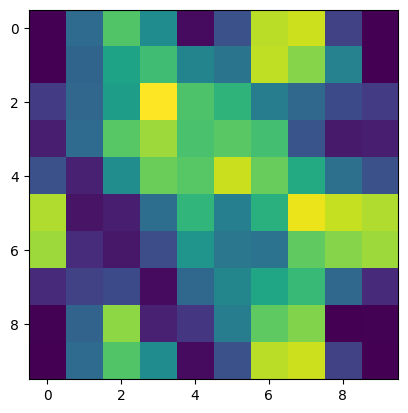

In [37]:
n = config.nmesh_size1d
plt.imshow(u0s[0].reshape((n,n,3))[:,:,0])

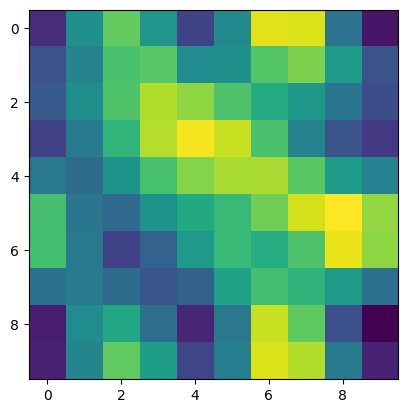

In [38]:
eval=jax.vmap(dn, (None, 0))(u0s[0],jnp.hstack((pts,0.0*jnp.ones((n**2,1)))))
plt.imshow(eval.reshape((n,n,3))[:,:,0])

In [39]:
# import jaxopt

def okloss(params):
    return loss(params, u0s_shard)



In [40]:
opt = jaxopt.LBFGS(okloss, value_and_grad=False)

In [41]:
state = opt.init_state(dn)

In [42]:
@jax.jit
def jitted_update(params, state):
    return opt.update(params, state)

In [43]:
for i in range(200):
    # print(i)
    dn, state = jitted_update(dn, state)
    mloss = loss(dn, u0s_shard)
    if i % 10 == 0:
        print(i, mloss)

0 109.798225
10 105.90576
20 105.317474
30 105.01149
40 104.88518
50 104.760765
60 104.59395
70 104.403175
80 104.1964
90 103.88153
100 103.53946
110 103.23119
120 102.78671
130 102.304184
140 101.89981
150 101.46403
160 101.04355
170 100.57507
180 100.11124
190 99.71559


In [52]:
icloss_tot(dn, u0s)

Array(63.97255, dtype=float32)

In [193]:
eqx.tree_serialise_leaves("ok.eqx", dn)
